In [1]:
# ---- Packages ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics
import pmdarima as pm
pd.plotting.register_matplotlib_converters()

c:\Users\Dell\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# ---- Data Transformations ----
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
               'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

In [19]:
df = pd.read_csv('station_sao_paulo.csv')
df = df[['YEAR'] + list(months_dict.keys())]

    YEAR     JAN     FEB     MAR     APR     MAY     JUN     JUL     AUG  \
0   1946  999.90  999.90  999.90  999.90  999.90  999.90  999.90  999.90   
1   1947  999.90   23.54   21.04   19.74   19.24  999.90   15.04   16.44   
2   1948   23.64   22.94   20.74   20.04   18.04   16.64   17.84   15.64   
3   1949   22.34   21.54   23.54   19.44   17.24   17.34   16.34   17.34   
4   1950   22.14   22.44   22.24   20.44   19.44   17.94   16.44   19.14   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
69  2015   26.35   24.60   23.15   22.00   19.25   18.70   18.60   20.65   
70  2016   23.60   25.30   23.90   24.25   18.60   16.10   18.40   18.90   
71  2017   23.85   25.00   22.65   21.10   19.40   18.60   17.30   18.30   
72  2018   23.90   23.25   24.95   22.20   20.15   19.20   19.55   17.85   
73  2019   26.55   24.15   23.95   23.45   21.55   19.80   18.05   18.80   

       SEP     OCT     NOV     DEC   D-J-F   M-A-M   J-J-A   S-O-N  metANN  
0   999.90

In [4]:
df_sp = pd.melt(df, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict})

df_sp['DAY'] = 1 #need a day for the pd.to_datetime() function
df_sp['DATE'] = pd.to_datetime(df_sp[['YEAR','MONTH','DAY']])
df_sp = df_sp[['DATE','Sum of Value']].rename(columns={'DATE':'date','Sum of Value':'temp'})
df_sp = df_sp.sort_values('date').reset_index(drop=True)

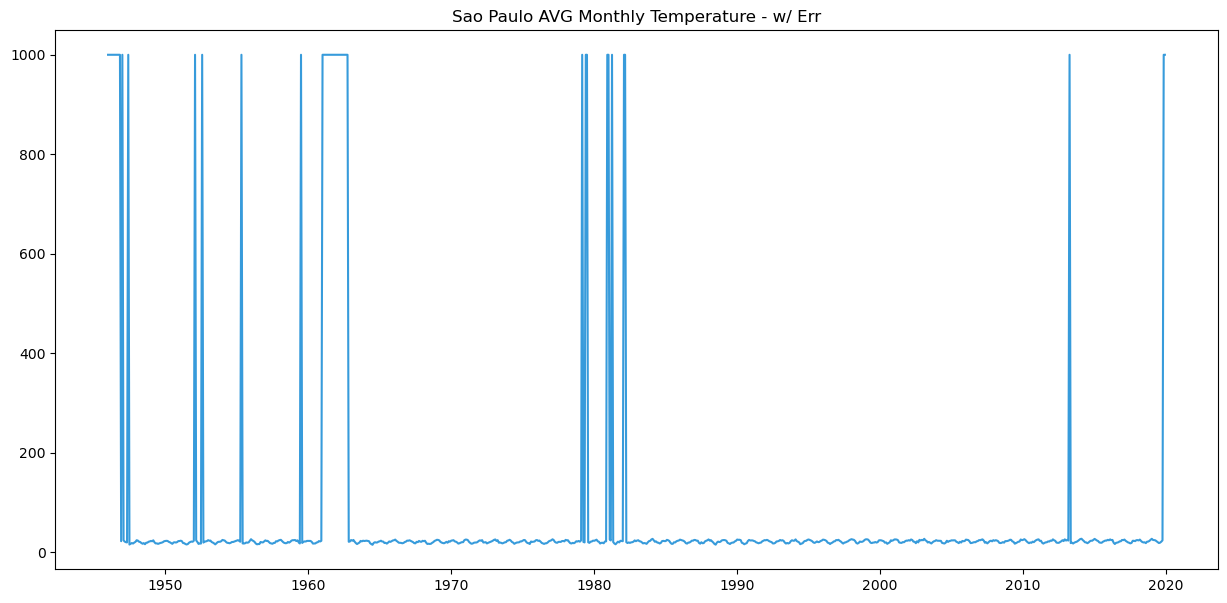

In [5]:
# ---- Visualize Data ----
plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - w/ Err")
plt.plot(df_sp["date"], df_sp['temp'], color='#379BDB', label='Original')
plt.show(block=False)

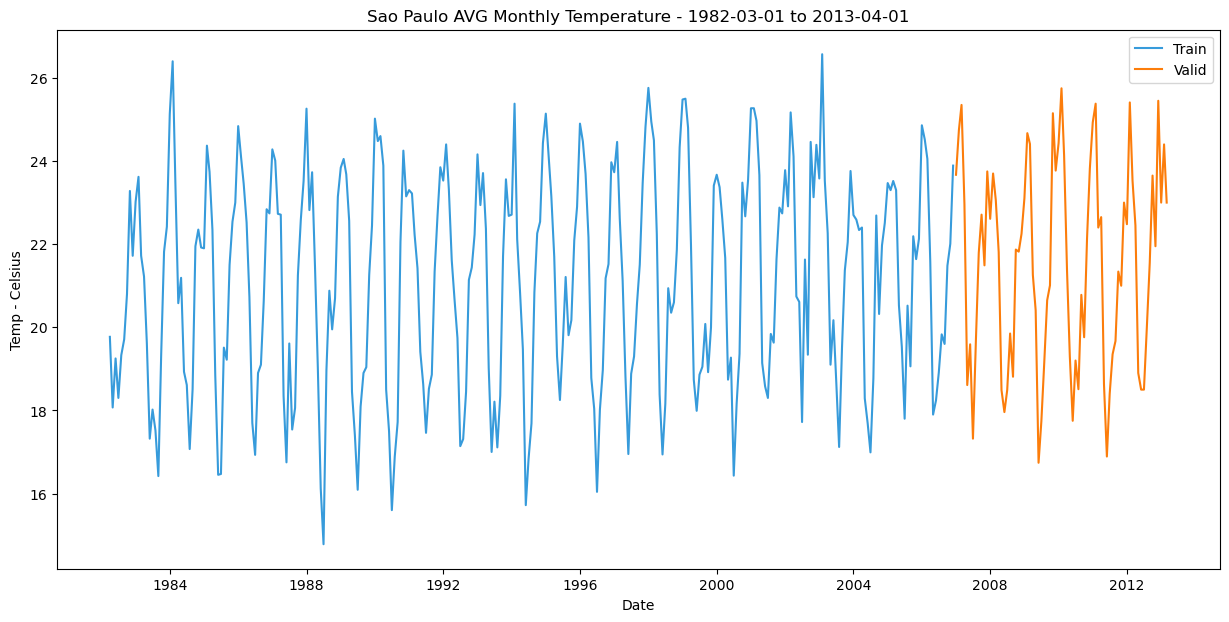

In [6]:
df_sp = df_sp[(df_sp['date'] > '1982-03-01') & (df_sp['date'] < '2013-04-01')]
df_sp = df_sp.set_index(df_sp['date'], drop=True).drop(columns=["date"])

train, valid = df_sp[:int(len(df_sp)*0.8)], df_sp[int(len(df_sp)*0.8):]

plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - 1982-03-01 to 2013-04-01")
plt.plot(train.index, train['temp'], color='#379BDB', label='Train')
plt.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
plt.xlabel('Date')
plt.ylabel('Temp - Celsius')
plt.legend()
plt.show(block=False)

In [7]:

SARIMA_model = pm.auto_arima(train['temp'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #annual frequency(12 for month, 7 for week etc) 
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [8]:

sarima_preds = []
df_sp.index = df_sp.index.to_period('M') 

for i in range(len(valid)):
    m_sarima = ARIMA(df_sp[:len(train)+i]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
residuals = sorted([x - y for x, y in zip(sarima_preds, valid['temp'].values)])

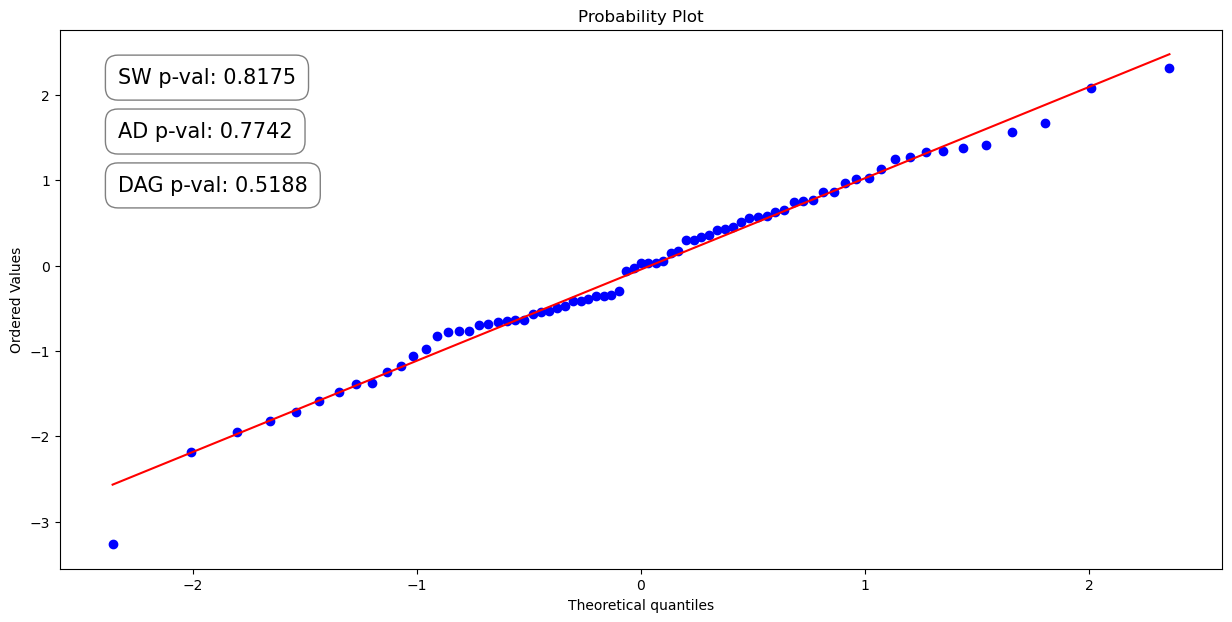

In [9]:
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

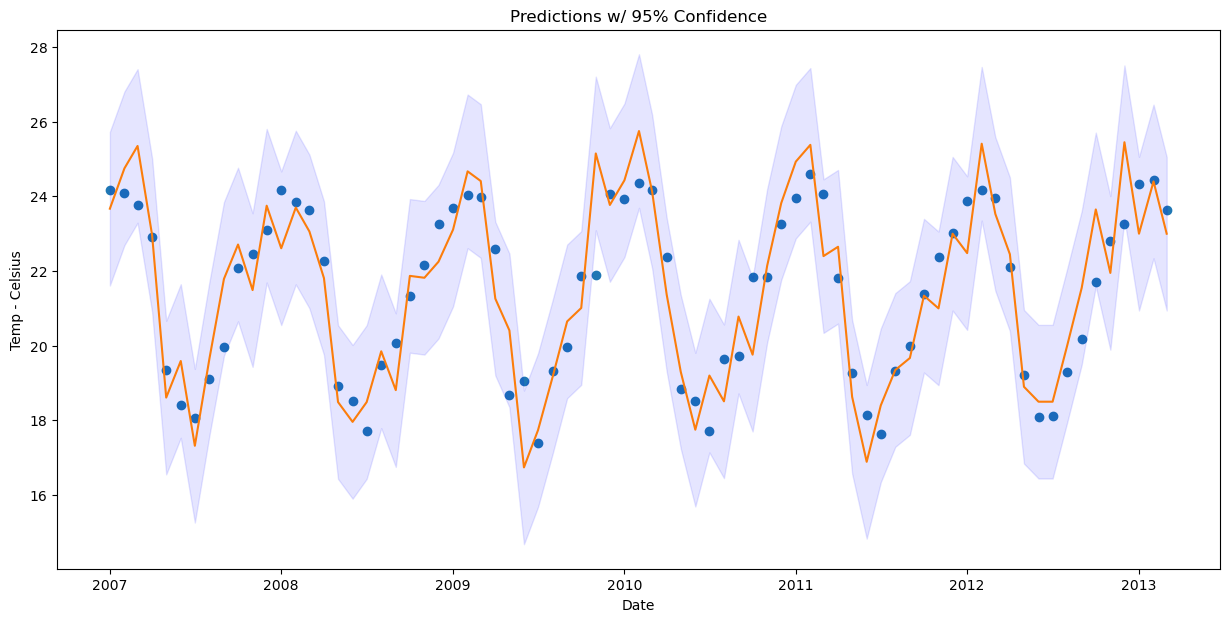

In [10]:

RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

In [11]:
crossval_count = 500
min_size = 250
max_random = len(df_sp) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    
    m_sarima = ARIMA(df_sp[start:end]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False).fit()
    pred = m_sarima.forecast(1).values[0]
    crossval_resids.append(pred - df_sp[end:end+1]['temp'].values[0])
    
bsed_residuals = sorted(crossval_resids)

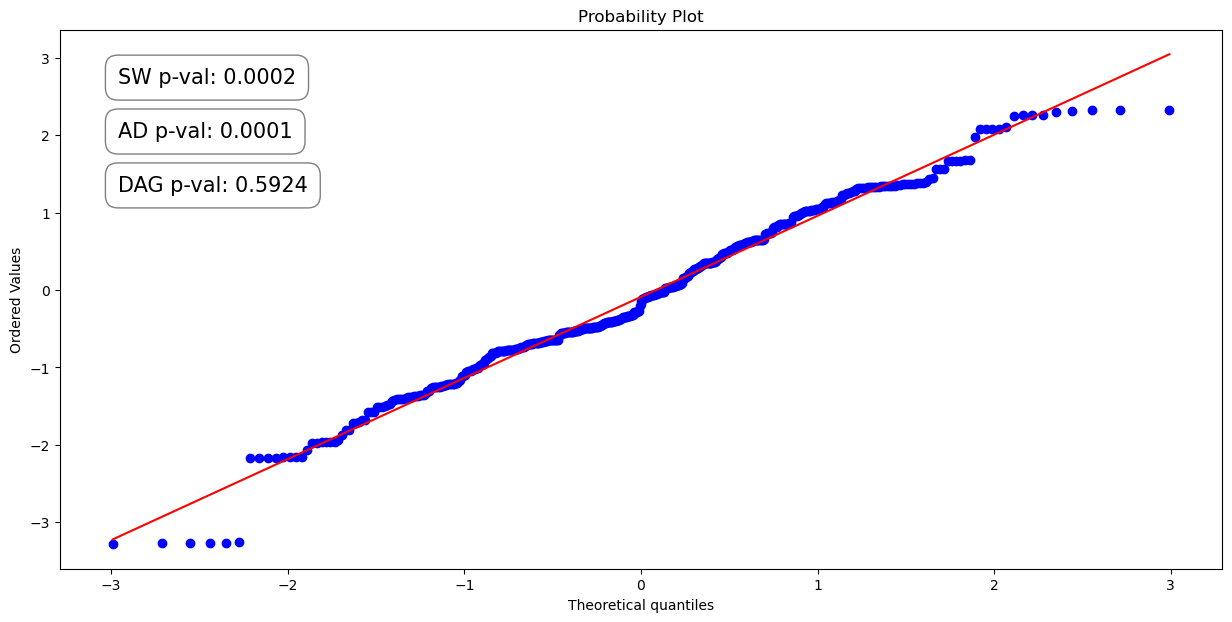

In [12]:

sw_result = stats.shapiro(bsed_residuals)
ad_result = normal_ad(np.array(bsed_residuals), axis=0)
dag_result = stats.normaltest(bsed_residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(bsed_residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

Early Stopping Iteration: 7500
Median of Bootstrapped STD's: 1.0458


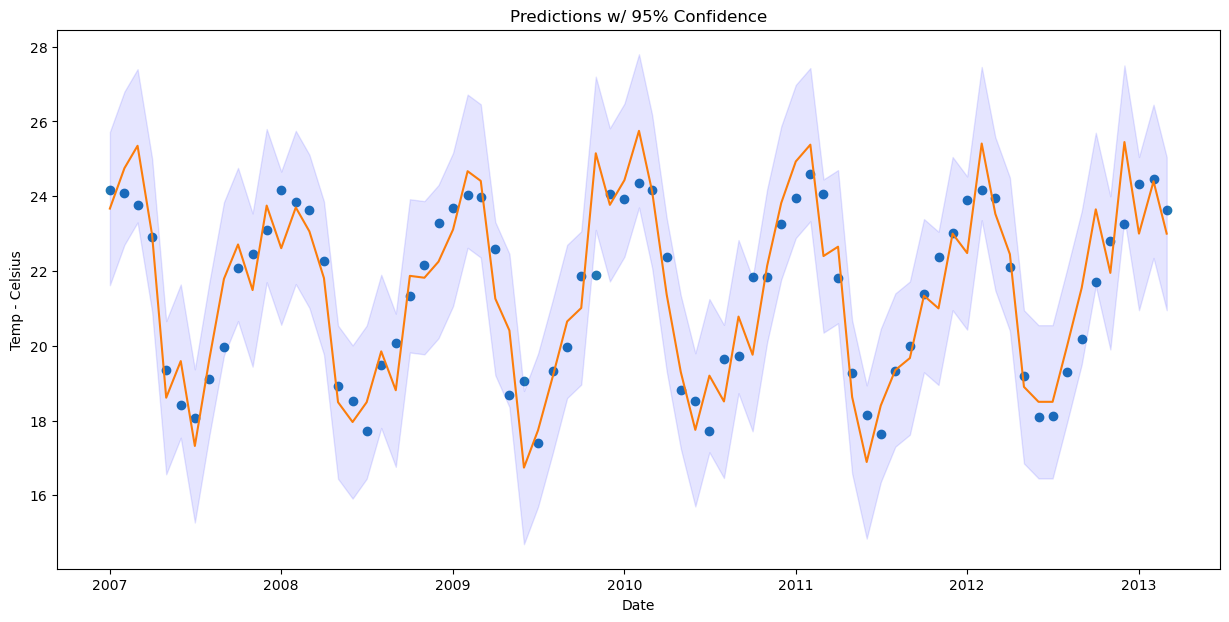

In [14]:
bs_stds=[]
last_std = None

for i in range(10000):
    samples = [bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))]
    bs_stds.append(np.std(samples))
    if i%500 == 0 and i!=0:
        if i == 500:
            last_std = np.median(bs_stds)
        else:
            current_std = np.median(bs_stds)
            if abs(current_std - last_std) < last_std*0.00001:
                print("Early Stopping Iteration: {}".format(i))
                break
            else:
                last_std = np.median(bs_stds)        
    
bs_std = np.median(bs_stds)
print("Median of Bootstrapped STD's: {:.4f}".format(bs_std))

bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-bs_band_size), (valid['temp']+bs_band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

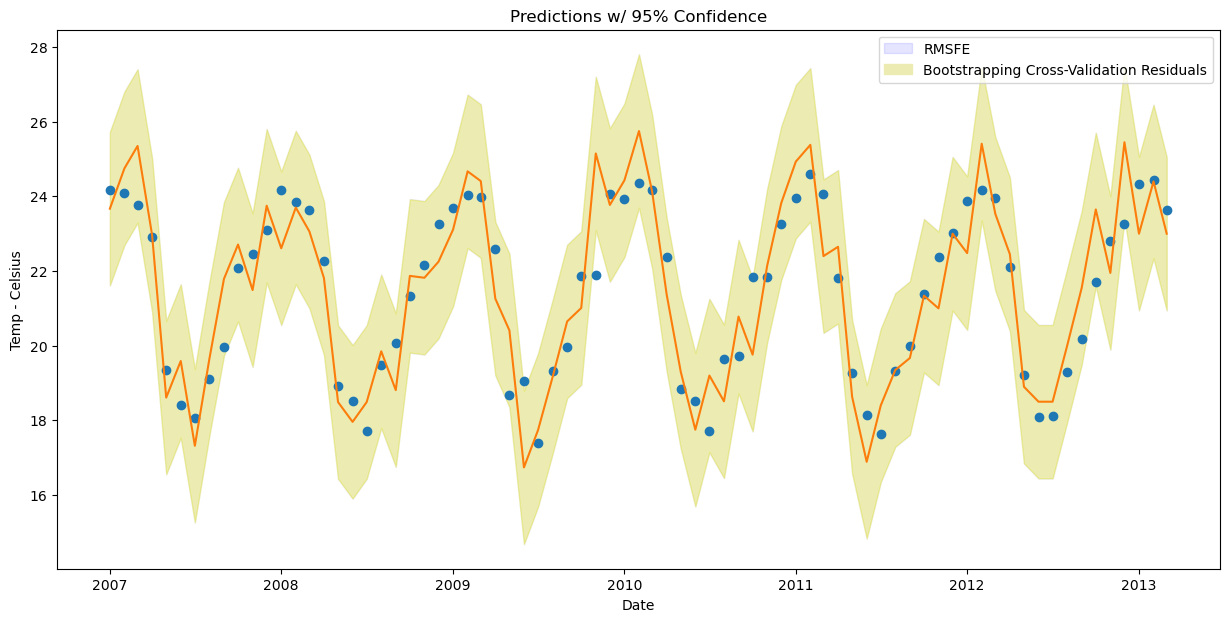

In [15]:
bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='blue', alpha=0.1)
ax.fill_between(valid.index, (valid['temp']-bs_band_size), (valid['temp']+bs_band_size), color='yellow', alpha=0.3)

ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)

ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')

patches = [Patch(color='blue', alpha=0.1), Patch(color='#ececb2')]
labels = ['RMSFE','Bootstrapping Cross-Validation Residuals']
ax.legend(patches, labels)

plt.show()